Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Weronika Pawlak"

---

In [2]:
%matplotlib inline
import math
from itertools import cycle
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.distributions as dist
from matplotlib import cm, patches, animation
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, load_iris
from tqdm.auto import trange

from IPython.display import HTML


SEED = 13

np.random.seed(SEED)
torch.manual_seed(SEED)
CMAP = plt.cm.get_cmap("Dark2", 8)


def visualize(
    points: Optional[np.ndarray] = None,
    gaussians: Optional[List[Tuple[np.ndarray, np.ndarray, float]]] = None,
    fig: Optional[plt.Figure] = None,
    lims: int = 2,
) -> Tuple[plt.Figure, Tuple[plt.Axes, ...]]:
    """Wizualizacja mikstury rozkładów normalnych.
    
    :param points: punkty 2D do wizualizacji
    :param gaussians: lista krotek zawierających
        macierz średnich, macierz kowariancji i mixing coefficients
    :param fig: figure do rysowania
    """
    handles = []
    labels = []
    if fig is None:
        fig = plt.figure(figsize=(14, 5))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133, projection="3d")
    else:
        ax1, ax2, ax3 = fig.get_axes()
        ax1.clear()
        ax2.clear()
        ax3.clear()
    
    ax1.set_xlim(-lims, lims)
    ax1.set_ylim(-lims, lims)
    ax2.set_xlim(-lims, lims)
    ax2.set_ylim(-lims, lims)
    ax3.set_xlim(-lims, lims)
    ax3.set_ylim(-lims, lims)
    ax3.set_zlim(0, 0.5)
        
    if points is not None:
        ax1.scatter(
            points[:, 0], 
            points[:, 1],
            s=4,
            c="black",
            alpha=0.3, 
            marker="x",
            label="punkty"
        )
        h, l = ax1.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    
    if gaussians is not None:
        cmap = cycle(CMAP(i) for i in range(len(gaussians)))
        x = np.linspace(-lims, lims, 201)
        y = np.linspace(-lims, lims, 201)
        xs, ys = np.meshgrid(x, y)
        positions = np.stack((xs, ys), axis=2)
        zs = np.zeros_like(xs)

        for idx, (mu, sigma, pi) in enumerate(gaussians):
            c = next(cmap)
            label = f"komponent {idx}"
            rv = multivariate_normal(mu, sigma)
            zk = rv.pdf(positions)
            zs += pi * zk
            contour = ax1.contour(xs, ys, zk, levels=3, colors=[c])
            handles.append(patches.Patch(color=c, label=label))
            labels.append(label)

        ax2.contour(xs, ys, zs, levels=5)

        ax3.plot_surface(xs, ys, zs, cmap=cm.coolwarm)
        
    fig.legend(handles, labels, loc='center left')
    return fig, (ax1, ax2, ax3)


def load_s_set() -> pd.DataFrame:
    """Load s_set dataset and standardize it."""
    data = pd.read_csv("s_set.csv", delimiter="\t", names=["x", "y"])
    return (data - data.mean(axis=0)) / data.std(axis=0)


In [3]:
grading = True  # ustaw na False!

In [22]:
grading = False

# Modele mikstur

Modele mikstury rozkładów normalnych (ang. *Gaussian Mixture Models*, **GMMs**) to jeden z *Latent Variable Models*. Zakładamy w nim, że obserwowane dane są generowane z mikstury skończonej liczby rozkładów normalnych o nieznanych parametrach. Poniżej przykład dla dwuwymiarowej przestrzeni.


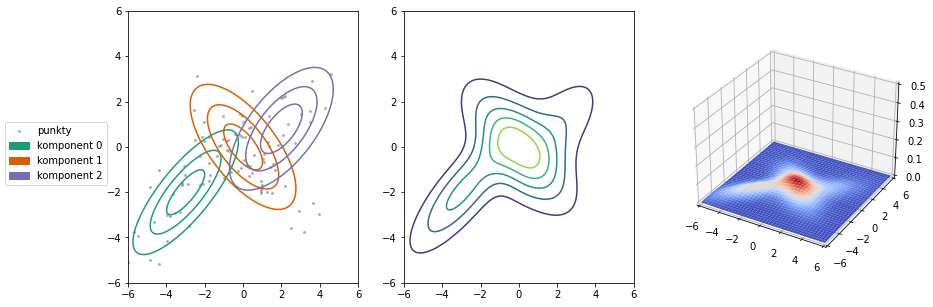

In [4]:
mu_0, sigma_0, pi_0 = np.array([-3.0, -2.0]), np.array([[3.0, 2.4],[2.4, 3.0]]), 0.3
mu_1, sigma_1, pi_1 = np.array([0.0, 0.0]), np.array([[3.0, -2.0], [-2.0, 3.0]]), 0.5
mu_2, sigma_2, pi_2 = np.array([2.0, 0.8]), np.array([[2.8, 1.8], [1.8, 2.8]]), 0.2

points_0 = np.random.multivariate_normal(mu_0, sigma_0, size=int(100 * pi_0))
points_1 = np.random.multivariate_normal(mu_1, sigma_1, size=int(100 * pi_1))
points_2 = np.random.multivariate_normal(mu_2, sigma_2, size=int(100 * pi_2))

visualize(
    points=np.vstack((points_0, points_1, points_2)),
    gaussians=[
        (mu_0, sigma_0, pi_0), 
        (mu_1, sigma_1, pi_1),
        (mu_2, sigma_2, pi_2)
    ],
    lims=6
)
plt.show()


W przypadku modelu mikstur rozkładów normalnych mówimy o komponentach - zmiennych losowych o rozkładzie normalnym, z których każdy posiada:

* **wektor średnich** $\pmb{\mu}$ określający środek rozkładu,
* **macierz kowariancji** $\pmb{\Sigma}$ określający jego szerokość,
* ***mixing coefficient*** $\pi$ mówiący o prawdopodobieństwie danego komponentu (ich suma musi być równa $1$).

Wówczas, dla wektora losowego $\pmb{x}$ funkcja gęstości GMM zdefiniowana jest w następujący sposób:

$$p\left(\pmb{x}\right) = \sum_{k=1}^{K} \pi_k \mathcal{N}\left(\pmb{x} \mid \pmb{\mu}_k, \pmb{\Sigma}_k\right)\tag{pdf}$$

Stosując GMM do *soft clustering* obliczamy prawdopodobieństwo posterior, że dany $n$-ty punkt należy do $k$-tego klastra - ***responsibility***.

$$\gamma\left(z_{nk}\right) := p\left(z_n=k \mid x_n, \pmb{\theta}\right) = \frac{p\left(z_i=k \mid \pmb{\theta}\right)p\left(x_n \mid z_n=k, \pmb{\theta}\right)}{\sum_{k'=1}^K p\left(z_n=k' \mid \pmb{\theta}\right)p\left(x_n \mid z_n=k', \pmb{\theta}\right)} = \frac{\pi_k \mathcal{N}\left(\pmb{x}_n \mid \pmb{\mu}_k, \pmb{\Sigma}_k\right)}{\sum_{j=1}^{K} \pi_j \mathcal{N}\left(\pmb{x}_n \mid \pmb{\mu}_j, \pmb{\Sigma}_j\right)}\tag{gamma}$$

## Expectation-Maximization

Rozkład $(pdf)$ możemy rozważać jako rozkład brzegowy $p\left(\pmb{x} \mid \pmb{\theta}\right)$, wówczas możemy wyprowadzić log-likelihood modelu dla zbioru danych $\mathcal{D}$.

$$\log p\left(\mathcal{D} \mid \pmb{\pi}, \pmb{\mu}, \pmb{\Sigma}\right) = \sum_{n=1}^{N} \log\left(\sum_{k=1}^K \pi_k \mathcal{N}\left(x_n \mid \pmb{\mu}_k, \pmb{\Sigma}_k\right)\right)\tag{LL}$$

Obliczając pochodne log-likelihood $(LL)$ (zgodnie z MLE) względem średnich $\pmb{\mu}_k$, kowariancji $\pmb{\Sigma}_k$, oraz używając *Lagrange coefficients* dla $\pi_k$ można wyprowadzić wzory na estymację parametrów rozkładów:

$$\pmb{\mu}_k^* = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) \pmb{x}_n\tag{means}$$
$$\pmb{\Sigma}_k^* = \frac{1}{N_k} \sum_{n=1}^N \gamma\left(z_{nk}\right)\left(\pmb{x}_n - \pmb{\mu}_k\right)\left(\pmb{x}_n - \pmb{\mu}_k\right)^T\tag{covariances}$$
$$\pi_k^* = \frac{N_k}{N}\tag{mixing coefs}$$
$$N_k = \sum_{n=1}^N \gamma\left(z_{nk}\right)$$

Równania te nie mają jawnej postaci ($\gamma\left(z_{nk}\right)$ zależy od pozostałych parametrów w złożony sposób i odwrotnie). Możemy jednak iteracyjnie szukać rozwiązania, wykorzystująć algorytm ***Expectation-Maximization*** (EM).

Algorytm EM dla GMM będzie postępował według następujących kroków:

1. Zainicjalizuj parametry $\pmb{\theta}$ ($\pmb{\mu}$, $\pmb{\Sigma}$, $\pmb{\pi}$)
1. Oblicz *responsibilities* $\gamma\left(z_{nk}\right)$ dla aktualnych wartości parametrów (*expectation step*)
1. Oblicz i zaktualizuj parametry ($\pmb{\mu}$, $\pmb{\Sigma}$, $\pmb{\pi}$) wykorzystując wartości *responsibilities* (*maximization step*).

Algorytm jest zatrzymywany po osiągnięciu określonej liczby kroków, gdy zmiana log-likelihood jest poniżej progu lub gdy zmiana parametrów jest poniżej progu.

W tym laboratorium zadanie będzie polegało na przygotowaniu i analizie algorytmu uczenia modelu mikstur rozkładów normalnych *Expectation-Maximization*. Wykorzystamy w tym celu dwa dwuwymiarowe zbiory: przykładowy zbiór *blobów* `toy_dataset` oraz rzeczywisty, wielomodalny zbiorze `s_data` (źródło: http://cs.joensuu.fi/sipu/datasets/). W ogólności jednak, GMM-y mogą być stosowane do wielowymiarowych danych.


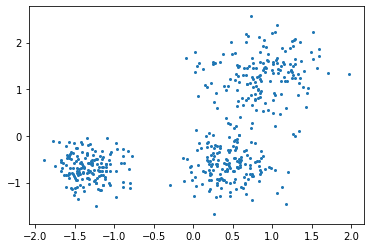

In [5]:
# zbiór do sanity check
blob, _ = make_blobs(
    500,
    random_state=0, 
    centers=((-3, -2), (4, 3), (2.5, -1.8)), 
    cluster_std=(0.7, 1.2, 0.9)
)
blob = (blob - blob.mean(axis=0)) / blob.std(axis=0)

plt.scatter(blob[:, 0], blob[:, 1], s=4)
plt.show()

toy_data = torch.from_numpy(blob).float()


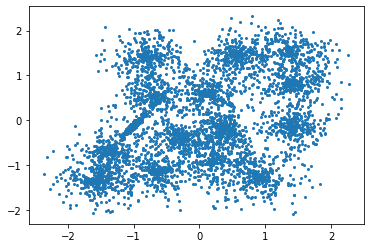

In [6]:
# zbiór złożony
s_set = load_s_set()

plt.scatter(s_set["x"], s_set["y"], s=4)
plt.show()

s_data = torch.from_numpy(s_set.to_numpy()).float()


## Zadanie 1. (2,5 p.)

Zaimplementuj etapy **Expectation** oraz **Maximization**, a także obliczanie **log-likelihood** dla dwuwymiarowego modelu mikstur rozkładów normalnych, używając metod z biblioteki `torch`. Wykorzystaj podane wzory oraz wiedzę z wykładu. Zwróć uwagę na efektywność przygotowywanego kodu. Sprawdź, czy Twoje funkcje zwracają poprawne wymiary danych używając testów. Następnie wykonaj komórki z uczeniem modelu oraz przygotuj animację uczenia dla zbioru `toy_data` oraz `s_data`; sprawdź, jak liczba komponentów wpływa na działanie modelu.

Animacja oraz wyświetlanie historii log-likelihood, jak również metoda uczenia modelu `fit` i jego inicjalizacja zostały już zaimplementowane.


In [7]:
class GaussianMixtureModel2d:
    distribution = dist.MultivariateNormal
    def __init__(
        self,
        n_components: int, 
        n_epochs: int = 50,
        termination_threshold: float = 1e-3, 
        verbose: bool = True
    ):
        """Inicjalizacja modelu dwuwymiarowego.
        
        :param n_components: liczba komponentów modelu
        :param n_epochs: liczba epok trenowania modelu
        :param termination_threshold: próg przyrostu log likelihood do zatrzymywania
        :param verbose: wyświetl informację o trenowaniu
        """
        self.history = {
            "means": [],
            "covariances": [],
            "mixing_coefs": [],
            "log_likelihood": []
        }
        
        self.n_components = n_components
        self.n_epochs = n_epochs
        self.dim = 2
        self.termination_threshold = termination_threshold
        self.verbose = verbose
        
        self.means = torch.rand((self.n_components, self.dim))
        self.covariances = torch.eye(self.dim).repeat(
            self.n_components, 1, 1
        )
        self.mixing_coefs = torch.full(
            (self.n_components,),
            fill_value=1 / self.n_components
        )
        
    def expectation_step(self, x: torch.Tensor) -> torch.Tensor:
        """Krok Expectation (obliczenie responsibilities)."""
        responsibilities = [[] for i in range(self.n_components)]
        #print(responsibilities)
        for x_n in x:
            parts = [self.mixing_coefs[k] * self.distribution(self.means[k],self.covariances[k]).log_prob(x_n).exp() \
                     for k in range(self.n_components)]
            total = sum(parts)
            for k in range(self.n_components):
                responsibilities[k].append(parts[k]/total)
        # oblicz responsibilities zgodnie z równaniem
        # TU WPISZ KOD
        #raise NotImplementedError()
        return torch.as_tensor(responsibilities)
        
    
    def maximization_step(
        self, x: torch.Tensor, responsibilities: torch.Tensor
    ):
        """Krok Maximization (obliczenie parametrów)."""
        # zaktualizuj parametry modelu zgodnie z równaniami
        # TU WPISZ KOD
        #raise NotImplementedError()
       
        means = [[] for i in range(self.n_components)]
        covariances = [[] for i in range(self.n_components)]
        mixing_coefs = [[] for i in range(self.n_components)]
        for k in range(self.n_components):
            N_k = sum(responsibilities[k])
            r_k = responsibilities[k].numpy()
            means[k] = ((1/N_k)*sum([r_k[idx]*x_n for idx, x_n in enumerate(x)])).numpy()
            covariances[k] = ((1/N_k)*sum([(r_k[idx]*np.diag((x_n - self.means[k]))*np.diag((x_n - self.means[k])).T) for idx, x_n in enumerate(x)]))\
            .numpy()
            mixing_coefs[k] = N_k/len(x)
            #print(mixing_coefs[k])
        
        #print(means)
        self.means = torch.as_tensor(means)
        self.covariances = torch.as_tensor(covariances)
        self.mixing_coefs = torch.as_tensor(mixing_coefs)
        
    def loglikelihood(self, x: torch.Tensor) -> float:
        """Log-likelihood modelu."""
        
        # oblicz średni log likelihood zgodnie z równaniem
        # TU WPISZ KOD
        #raise NotImplementedError()
        logprob = []
        for x_n in x:
            parts = [self.mixing_coefs[k] * self.distribution(self.means[k],self.covariances[k]).log_prob(x_n).exp() \
                     for k in range(self.n_components)]
            total = np.log(sum(parts))
            logprob.append(total)
        avg_logprob = np.mean(logprob)
        return avg_logprob
    
    def update_history(self, x: torch.Tensor):
        """Aktualizacja logu."""
        self.history["means"].append(self.means)
        self.history["covariances"].append(self.covariances)
        self.history["mixing_coefs"].append(self.mixing_coefs)
        self.history["log_likelihood"].append(self.loglikelihood(x))
    
    def fit(self, x: torch.Tensor) -> float:
        """Trenowanie modelu."""
        self.update_history(x)
        for epoch in trange(self.n_epochs):
            responsibilities = self.expectation_step(x)
            self.maximization_step(x, responsibilities)
            self.update_history(x)
            if (
                self.history["log_likelihood"][-1] - self.history["log_likelihood"][-2] 
                < self.termination_threshold
            ):
                print("Log likelihood not increasing, stopping.")
                self.n_epochs = epoch
                break
        
        if self.verbose:
            self._plot_training()
        
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Predykcja posterior dla każdego z komponentów."""
        return self.expectation_step
        
    def _plot_training(self):
        """Wizualizacja uczenia."""
        fig, ax = plt.subplots()
        ax.plot(self.history["log_likelihood"])
        ax.set_xlabel("Epoka")
        ax.set_ylabel("Log likelihood")
        plt.show()
        
    def animation(self, x: torch.Tensor):
        """Animacja uczenia modelu."""
        fig, axes = visualize(points=x.numpy())
        anim = animation.FuncAnimation(
            fig=fig,
            func=lambda i: visualize(
                points=x.numpy(),
                gaussians=[
                    (mu, sigma, pi)
                    for mu, sigma, pi 
                    in zip(
                        self.history["means"][i].numpy(),
                        self.history["covariances"][i].numpy(),
                        self.history["mixing_coefs"][i].numpy(),
                    )
                ],
                fig=fig
            ), 
            frames=range(0, self.n_epochs, 5 if self.n_epochs > 10 else 1), 
            interval=500,
            blit=False
        )
        plt.close()
        return anim.to_jshtml()
    
    def sample(
        self, sample_shape: torch.Size = torch.Size([])
    ) -> torch.Tensor:
        """Próbkuj z modelu mikstur."""
        result = []
        for i in range(sample_shape):
            c = dist.Categorical(self.mixing_coefs)
            k = c.sample()
            m = self.distribution(self.means[k], self.covariances[k]).sample().numpy()
            result.append(m)
        
        return torch.as_tensor(result)

In [8]:
from nose.tools import assert_almost_equal

n_components = 3
n_examples = 5
test_x = torch.rand(n_examples, 2)

# parametry modelu
test_model = GaussianMixtureModel2d(n_components, n_epochs=1, verbose=False)
means_shape = test_model.means.shape
covariances_shape = test_model.covariances.shape
mixing_coefs_shape = test_model.mixing_coefs.shape
assert test_model.n_components == n_components
assert means_shape == (n_components, 2)
assert covariances_shape == (n_components, 2, 2)
assert mixing_coefs_shape == (n_components,)

log_likelihood_1 = test_model.loglikelihood(test_x)

# responsibilities
responsibilities = test_model.expectation_step(test_x)
assert responsibilities.numel() == n_components * n_examples
assert type(responsibilities) == torch.Tensor

# parametry po aktualizacji
test_model.maximization_step(test_x, responsibilities)
assert test_model.means.shape == means_shape
assert test_model.covariances.shape == covariances_shape
assert test_model.mixing_coefs.shape == mixing_coefs_shape

log_likelihood_2 = test_model.loglikelihood(test_x)

assert log_likelihood_1 < log_likelihood_2



Log likelihood not increasing, stopping.


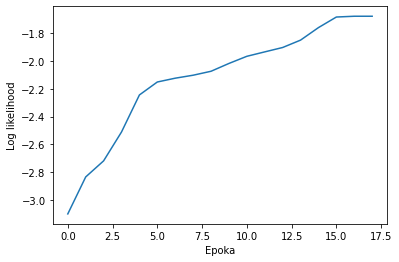

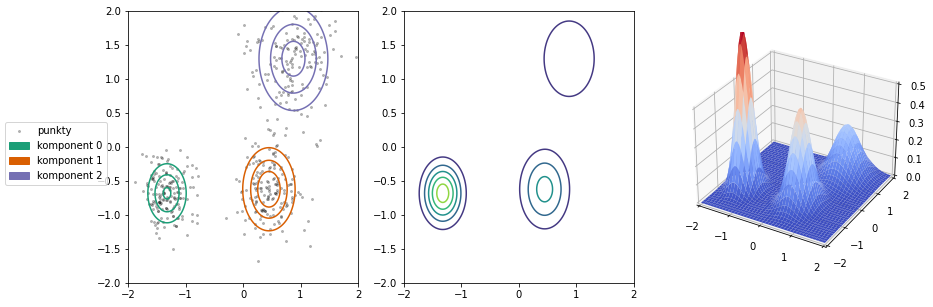

In [9]:
model = GaussianMixtureModel2d(3, n_epochs=50)
model.fit(toy_data)
if not grading:
    display(HTML(model.animation(toy_data)))
else:
    visualize(
        points=toy_data.numpy(),
        gaussians=[
            (mu, sigma, pi)
            for mu, sigma, pi 
            in zip(
                model.means.numpy(),
                model.covariances.numpy(),
                model.mixing_coefs.numpy(),
            )
        ],
    )


Log likelihood not increasing, stopping.


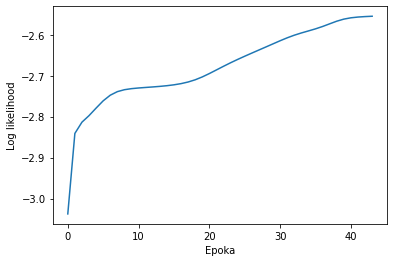

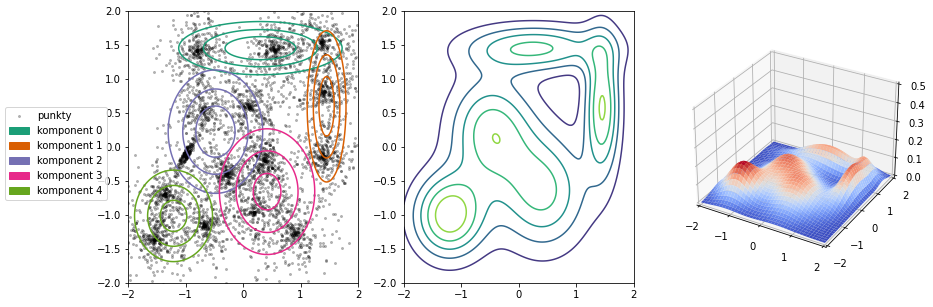

In [10]:
model = GaussianMixtureModel2d(5, n_epochs=50)
model.fit(s_data)
if not grading:
    display(HTML(model.animation(s_data)))
else:
    visualize(
        points=s_data.numpy(),
        gaussians=[
            (mu, sigma, pi)
            for mu, sigma, pi 
            in zip(
                model.means.numpy(),
                model.covariances.numpy(),
                model.mixing_coefs.numpy(),
            )
        ],
    )



## Zadanie 2. (0,5 p.)

Losowy dobór początkowych średnich dla wszystkich komponentów może nie być najlepszym rozwiazaniem - modele mikstur są podatne na lokalne ekstrema. Jedną z interesujących metod inicjalizacji średnich modelu jest wykorzystanie klasteryzacji K-Means.

Użyj implementacji [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) z biblioteki scikit-learn do zainicjalizowania średnich każdego z komponentów modelu. Zadanie wykonaj tworząc klasę dziedziczącą po oryginalnej klasie GMM. Sprawdź działanie modelu dla obu zbiorów danych i porównaj z modelem inicjalizowanym losowo.


In [11]:
class GaussianMixtureModel2dKMeans(GaussianMixtureModel2d):
    """GMM z inicjalizacją średnich z użyciem KMeans."""
    # Zainicjalizuj średnie używając KMeans i wywołaj uczenie
    # TU WPISZ KOD
    def __init__(
        self,
        n_components: int, 
        n_epochs: int = 50,
        termination_threshold: float = 1e-3, 
        verbose: bool = True
    ):
        super().__init__(
            n_components, 
            n_epochs,
            termination_threshold, 
            verbose
        )
        self.kmeans = KMeans(n_clusters=self.n_components)
        
    def fit(self, x: torch.Tensor) -> float:
        self.kmeans = self.kmeans.fit(x)
        self.means = torch.as_tensor(self.kmeans.cluster_centers_.astype(np.float32))
        super().fit(x)

Log likelihood not increasing, stopping.


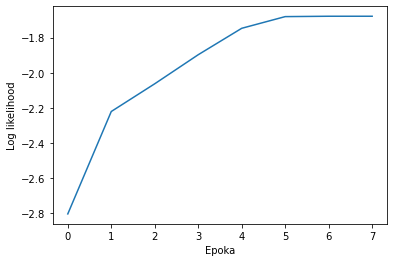

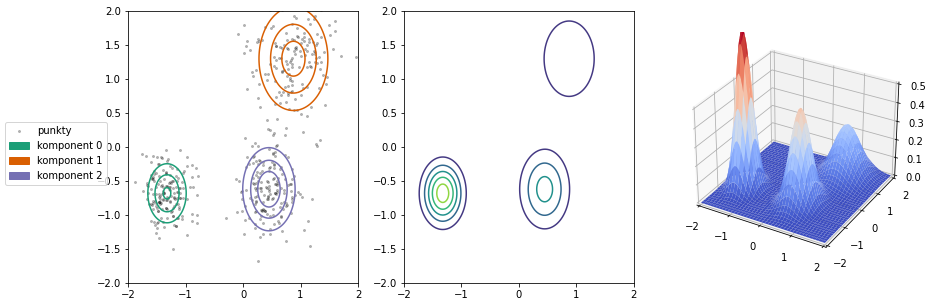

In [12]:
model = GaussianMixtureModel2dKMeans(3, n_epochs=20)
model.fit(toy_data)
if not grading:
    display(HTML(model.animation(toy_data)))
else:
    visualize(
        points=toy_data.numpy(),
        gaussians=[
            (mu, sigma, pi)
            for mu, sigma, pi 
            in zip(
                model.means.numpy(),
                model.covariances.numpy(),
                model.mixing_coefs.numpy(),
            )
        ],
    )


Log likelihood not increasing, stopping.


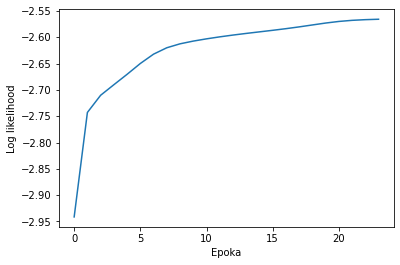

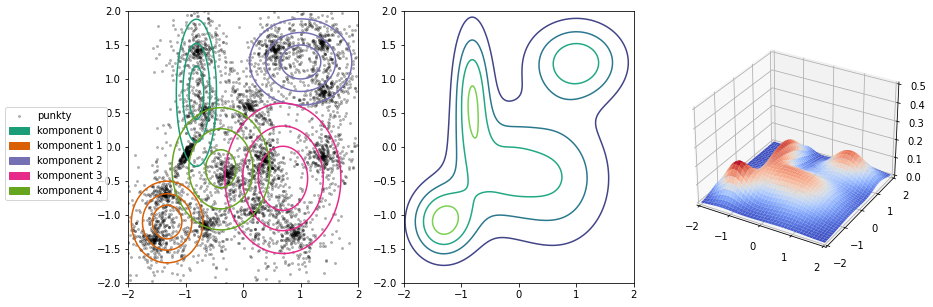

In [13]:
model = GaussianMixtureModel2dKMeans(5, n_epochs=50)
model.fit(s_data)
if not grading:
    display(HTML(model.animation(s_data)))
else:
    visualize(
        points=s_data.numpy(),
        gaussians=[
            (mu, sigma, pi)
            for mu, sigma, pi 
            in zip(
                model.means.numpy(),
                model.covariances.numpy(),
                model.mixing_coefs.numpy(),
            )
        ],
    )



## Zadanie 3. (1 p.)

Model mikstur mogą być wykorzystywane jako modele generujące. Zaimplementuj w klasie nadrzędnej modelu metodę `sample`, która wykona operację próbkowania: najpierw wylosuj komponent, wykorzystując *mixing coefficients*, a następnie dokonaj próbkowania z wybranego rozkładu i zwróć punkt (lub punkty). Porównaj PDF dla mikstury rozkładów oraz po próbkowaniu dużej liczby punktów z modelu (wskazówka: zainspiruj się kodem z funkcji `visualize` by przygotować wizualizację 2D i 3D oraz wykorzystaj metodę `np.histogram2d` dla wypróbkowanych punktów - zwróć uwagę na osie x i y, które są w niej zamienione).

UWAGA: zalecamy, by liczba próbkowań nie była większa niż `100_000` (przy założeniu użycia wektoryzowanego próbkowania z `torch`).


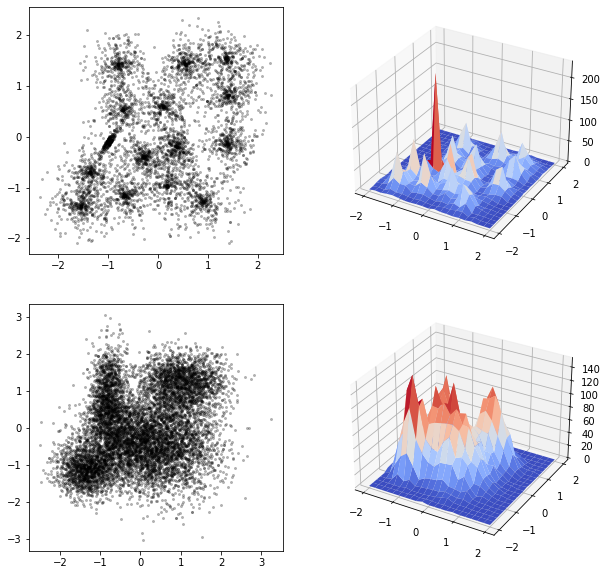

In [18]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)                   # wykres 2D dla mikstury rozkładów
ax2 = fig.add_subplot(222, projection="3d")  # wykres 3D dla mikstury rozkładów
ax3 = fig.add_subplot(223)                   # wykres 2D dla wypróbkowanych punktów
ax4 = fig.add_subplot(224, projection="3d")  # wykres 3D dla wypróbkowanych punktów


min_val, max_val = -2, 2                     # zakres dla osi X i Y
n_bins = 21                                  # liczba przedziałów dla histogramu oraz wizualizacji mikstury rozkładów
x = np.linspace(min_val, max_val, n_bins)
y = np.linspace(min_val, max_val, n_bins)
xs, ys = np.meshgrid(x, y)

sample = model.sample(10000)
points_old=s_data.numpy()

ax1.scatter(
            points_old[:, 0], 
            points_old[:, 1],
            s=4,
            c="black",
            alpha=0.3, 
            marker="x",
            label="punkty"
        )
zs = np.histogram2d(points_old[:,1], points_old[:, 0], bins=n_bins)[0]
ax2.plot_surface(xs, ys, zs, cmap=cm.coolwarm)
ax3.scatter(
            sample[:, 0], 
            sample[:, 1],
            s=4,
            c="black",
            alpha=0.3, 
            marker="x",
            label="punkty"
        )

zs = np.histogram2d(sample[:,1].numpy(), sample[:, 0].numpy(), bins=n_bins)[0]
ax4.plot_surface(xs, ys, zs, cmap=cm.coolwarm)
# TU WPISZ KOD
#raise NotImplementedError()
plt.show()


## Dobór liczby komponentów

Dotychczas wyboru liczby komponentów w miksturze dokonywaliśmy empirycznie. Podejściem bardziej metodycznym byłoby przygotowanie modeli o różnej liczbie komponentów i sprawdzenie, który z nich osiąga najwyższą wartość likelihood dla danych. Alternatywnie, dobór liczby komponentów można by oprzeć na kryterium analitycznym. W literaturze najczęściej wykorzystuje się **Akaike Information Criterion (AIC)** (równanie $(AIC)$) oraz **Bayesian Information Criterion (BIC)** (równanie $(BIC)$). Również i tutaj wybór modelu oparty jest na maksymalnej wartości kryterium.

$$\mathit{AIC}=\ln\left(\hat{L}\right) - M\tag{AIC}$$

$$\mathit{BIC}=\ln\left(\hat{L}\right) - \frac{1}{2} M \ln N\tag{BIC}$$

gdzie $M$ to liczba estymowanych parametrów w modelu, $N$ to liczba punktów w danych, a $\ln\left(\hat{L}\right)$ to najwyższa wartość log-likelihood. Porównując AIC i BIC widać, że BIC bardziej penalizuje złożoność modelu.


## Zadanie 4. (1 p.)

Zaimplementuj metryki AIC i BIC według wzorów. Następnie zbadaj, dla jakiej liczby komponentów z przedziału $\{1, ..., 15\}$ GMM osiąga najlepsze wartości obu kryteriów oraz log-likelihood dla zbioru `s_set`. Zapisz swoje obserwacje.

UWAGA: tutaj za likelihood bierzemy sumę dla wszystkich obserwacji


In [19]:
def aic(x: torch.Tensor, model: GaussianMixtureModel2d) -> float:
    aic = model.loglikelihood(x) - x.shape[1]
    """Oblicz wartość AIC dla danych i parametrów modelu."""
    
    # TU WPISZ KOD
    return aic.item()


def bic(x: torch.Tensor, model: GaussianMixtureModel2d) -> float:
    bic = model.loglikelihood(x) - (x.shape[1]/2)*np.log(x.shape[0])
    """Oblicz wartość BIC dla danych i parametru modelu."""
    # TU WPISZ KOD
    return bic.item()
    

In [20]:
from nose.tools import assert_almost_equal

test_model.fit(test_x)
assert type(aic(test_x, test_model)) == float
assert type(bic(test_x, test_model)) == float



In [ ]:
if not grading:
    log_dict = {"components": [], "aic": [], "bic": [], "log_likelihood": []}
    for n_components in range(1, 16):
        print(f"Training for {n_components} components")
        model = GaussianMixtureModel2dKMeans(n_components, n_epochs=100, verbose=False)
        model.fit(s_data)
        log_dict["components"].append(n_components)
        log_dict["log_likelihood"].append(s_data.shape[0] * max(model.history["log_likelihood"]))
        log_dict["aic"].append(aic(s_data, model))
        log_dict["bic"].append(bic(s_data, model))

    df = pd.DataFrame(log_dict)
    df.plot("components", ["aic", "bic", "log_likelihood"])
    plt.show()


Training for 1 components


Log likelihood not increasing, stopping.
Training for 2 components


Log likelihood not increasing, stopping.
Training for 3 components


Log likelihood not increasing, stopping.
Training for 4 components


Log likelihood not increasing, stopping.
Training for 5 components


Log likelihood not increasing, stopping.
Training for 6 components


Log likelihood not increasing, stopping.
Training for 7 components


Log likelihood not increasing, stopping.
Training for 8 components


Log likelihood not increasing, stopping.
Training for 9 components
